
# SPATIO-TEMPORAL CRIME PREDICTION USING DYNAMIC MODE DECOMPOSITION (DMD) AND CONVOLUTIONAL NEURAL NETWORK LONG-SHORT TERM MEMORY (CNN-LSTM) 
## Adrian Joseph Albino, Julian Ernest Camello
### This notebook documents the implementation of our thesis paper

![Conceptual Framework](conceptual_framework.png)

# Dataset
[SF Incident Report](https://www.kaggle.com/datasets/vivovinco/san-francisco-incident-reports-2018present)


In [18]:
import pandas as pd
    
file_path = 'Subset_Police_Department_Incident_Reports__2018_to_Present.csv'
df = pd.read_csv(file_path)
df.head()

,Incident Date,Latitude,Longitude
0,2018-01-01,37.720151,-122.449279
1,2018-01-01,37.710732,-122.418772
2,2018-01-01,37.788699,-122.420307
3,2018-01-01,37.740427,-122.492706
4,2018-01-01,37.783214,-122.410765


# Preprocessing

## Filtering & Removing Other Columns

In [19]:
columns_to_keep = ['Incident Date', 'Latitude', 'Longitude']
df.dropna(subset=columns_to_keep, inplace=True)
df = df[columns_to_keep]
df.head()


,Incident Date,Latitude,Longitude
0,2018-01-01,37.720151,-122.449279
1,2018-01-01,37.710732,-122.418772
2,2018-01-01,37.788699,-122.420307
3,2018-01-01,37.740427,-122.492706
4,2018-01-01,37.783214,-122.410765


## Aggregating By Date

In [20]:
df['Incident Date'] = pd.to_datetime(df['Incident Date'])
crime_by_date = df.groupby(pd.Grouper(key='Incident Date', freq='D'))
crime_by_date.head()

,Incident Date,Latitude,Longitude
0,2018-01-01,37.720151,-122.449279
1,2018-01-01,37.710732,-122.418772
2,2018-01-01,37.788699,-122.420307
3,2018-01-01,37.740427,-122.492706
4,2018-01-01,37.783214,-122.410765
...,...,...,...
12054,2018-01-31,37.786181,-122.475504
12055,2018-01-31,37.777602,-122.424809
12056,2018-01-31,37.786748,-122.405346
12057,2018-01-31,37.778604,-122.402385


In [21]:
specific_date = '2018-01-01'  
specific_date_data = crime_by_date.get_group(specific_date)
print(specific_date_data)

    Incident Date   Latitude   Longitude
0      2018-01-01  37.720151 -122.449279
1      2018-01-01  37.710732 -122.418772
2      2018-01-01  37.788699 -122.420307
3      2018-01-01  37.740427 -122.492706
4      2018-01-01  37.783214 -122.410765
..            ...        ...         ...
519    2018-01-01  37.786101 -122.418088
520    2018-01-01  37.778719 -122.414741
521    2018-01-01  37.764664 -122.404497
522    2018-01-01  37.808111 -122.409050
523    2018-01-01  37.755621 -122.395763

[524 rows x 3 columns]


## Aggregation By Cluster

In [22]:
import geopandas as gpd

sf_geojson = "SanFrancisco.Neighborhoods.json"
sf_neighborhoods = gpd.read_file(sf_geojson, driver='GeoJSON')

DAYS = 100

def count_crimes_by_neighborhood(date, crimes_group):
    crimes_group = gpd.GeoDataFrame(crimes_group, geometry=gpd.points_from_xy(crimes_group['Longitude'], crimes_group['Latitude']))
    crimes_group.crs = 'EPSG:4326'
    crimes_with_neighborhoods = gpd.sjoin(crimes_group, sf_neighborhoods, how="left", predicate="within")
    counts = crimes_with_neighborhoods.groupby('neighborhood').size()
    # Set count to 0 for neighborhoods with no crimes
    counts = counts.reindex(sf_neighborhoods['neighborhood']).fillna(0).astype(int)
    return pd.DataFrame({'date': date, 'neighborhood': counts.index, 'crime_count': counts.values})

crime_by_cluster = []

counter = 0
for date, crimes_group in crime_by_date:
     # LIMITS THE NUMBER OF DAYS TO PROCESS
    if (counter == DAYS):
        break #
    counter += 1
    
    counts_df = count_crimes_by_neighborhood(date, crimes_group)
    crime_by_cluster.append(counts_df['crime_count'].tolist())


print(crime_by_cluster[:5])

         date           neighborhood  crime_count
0  2018-01-01            Rincon Hill           13
1  2018-01-01            South Beach           38
2  2018-01-01              Chinatown           20
3  2018-01-01               Nob Hill           36
4  2018-01-01              Ingleside           31
5  2018-01-01                 Castro           14
6  2018-01-01                 Sunset            9
7  2018-01-01                Bayview           38
8  2018-01-01                Portola            2
9  2018-01-01            Lake Merced           17
10 2018-01-01             Twin Peaks            5
11 2018-01-01            North Beach           30
12 2018-01-01             Tenderloin           56
13 2018-01-01                   SoMa           41
14 2018-01-01                Mission           38
15 2018-01-01     Financial District           11
16 2018-01-01  Lower Pacific Heights           24
17 2018-01-01                Taraval            9
18 2018-01-01              Panhandle           28


## Time Series Splitting

In [23]:
from math import ceil

TRAIN_PERCENT = 0.8
TEST_PERCENT = 0.2

total_length = len(crime_by_cluster)
train_data_length = ceil(total_length * TRAIN_PERCENT)
test_data_length = total_length - train_data_length

# Split the data into training and testing sets
train_data = crime_by_cluster[:train_data_length]
test_data = crime_by_cluster[train_data_length:]

print("Train data length:", len(train_data))
print("Test data length:", len(test_data))

Train data length: 25
Test data length: 6


## Dynamic Mode Decomposition

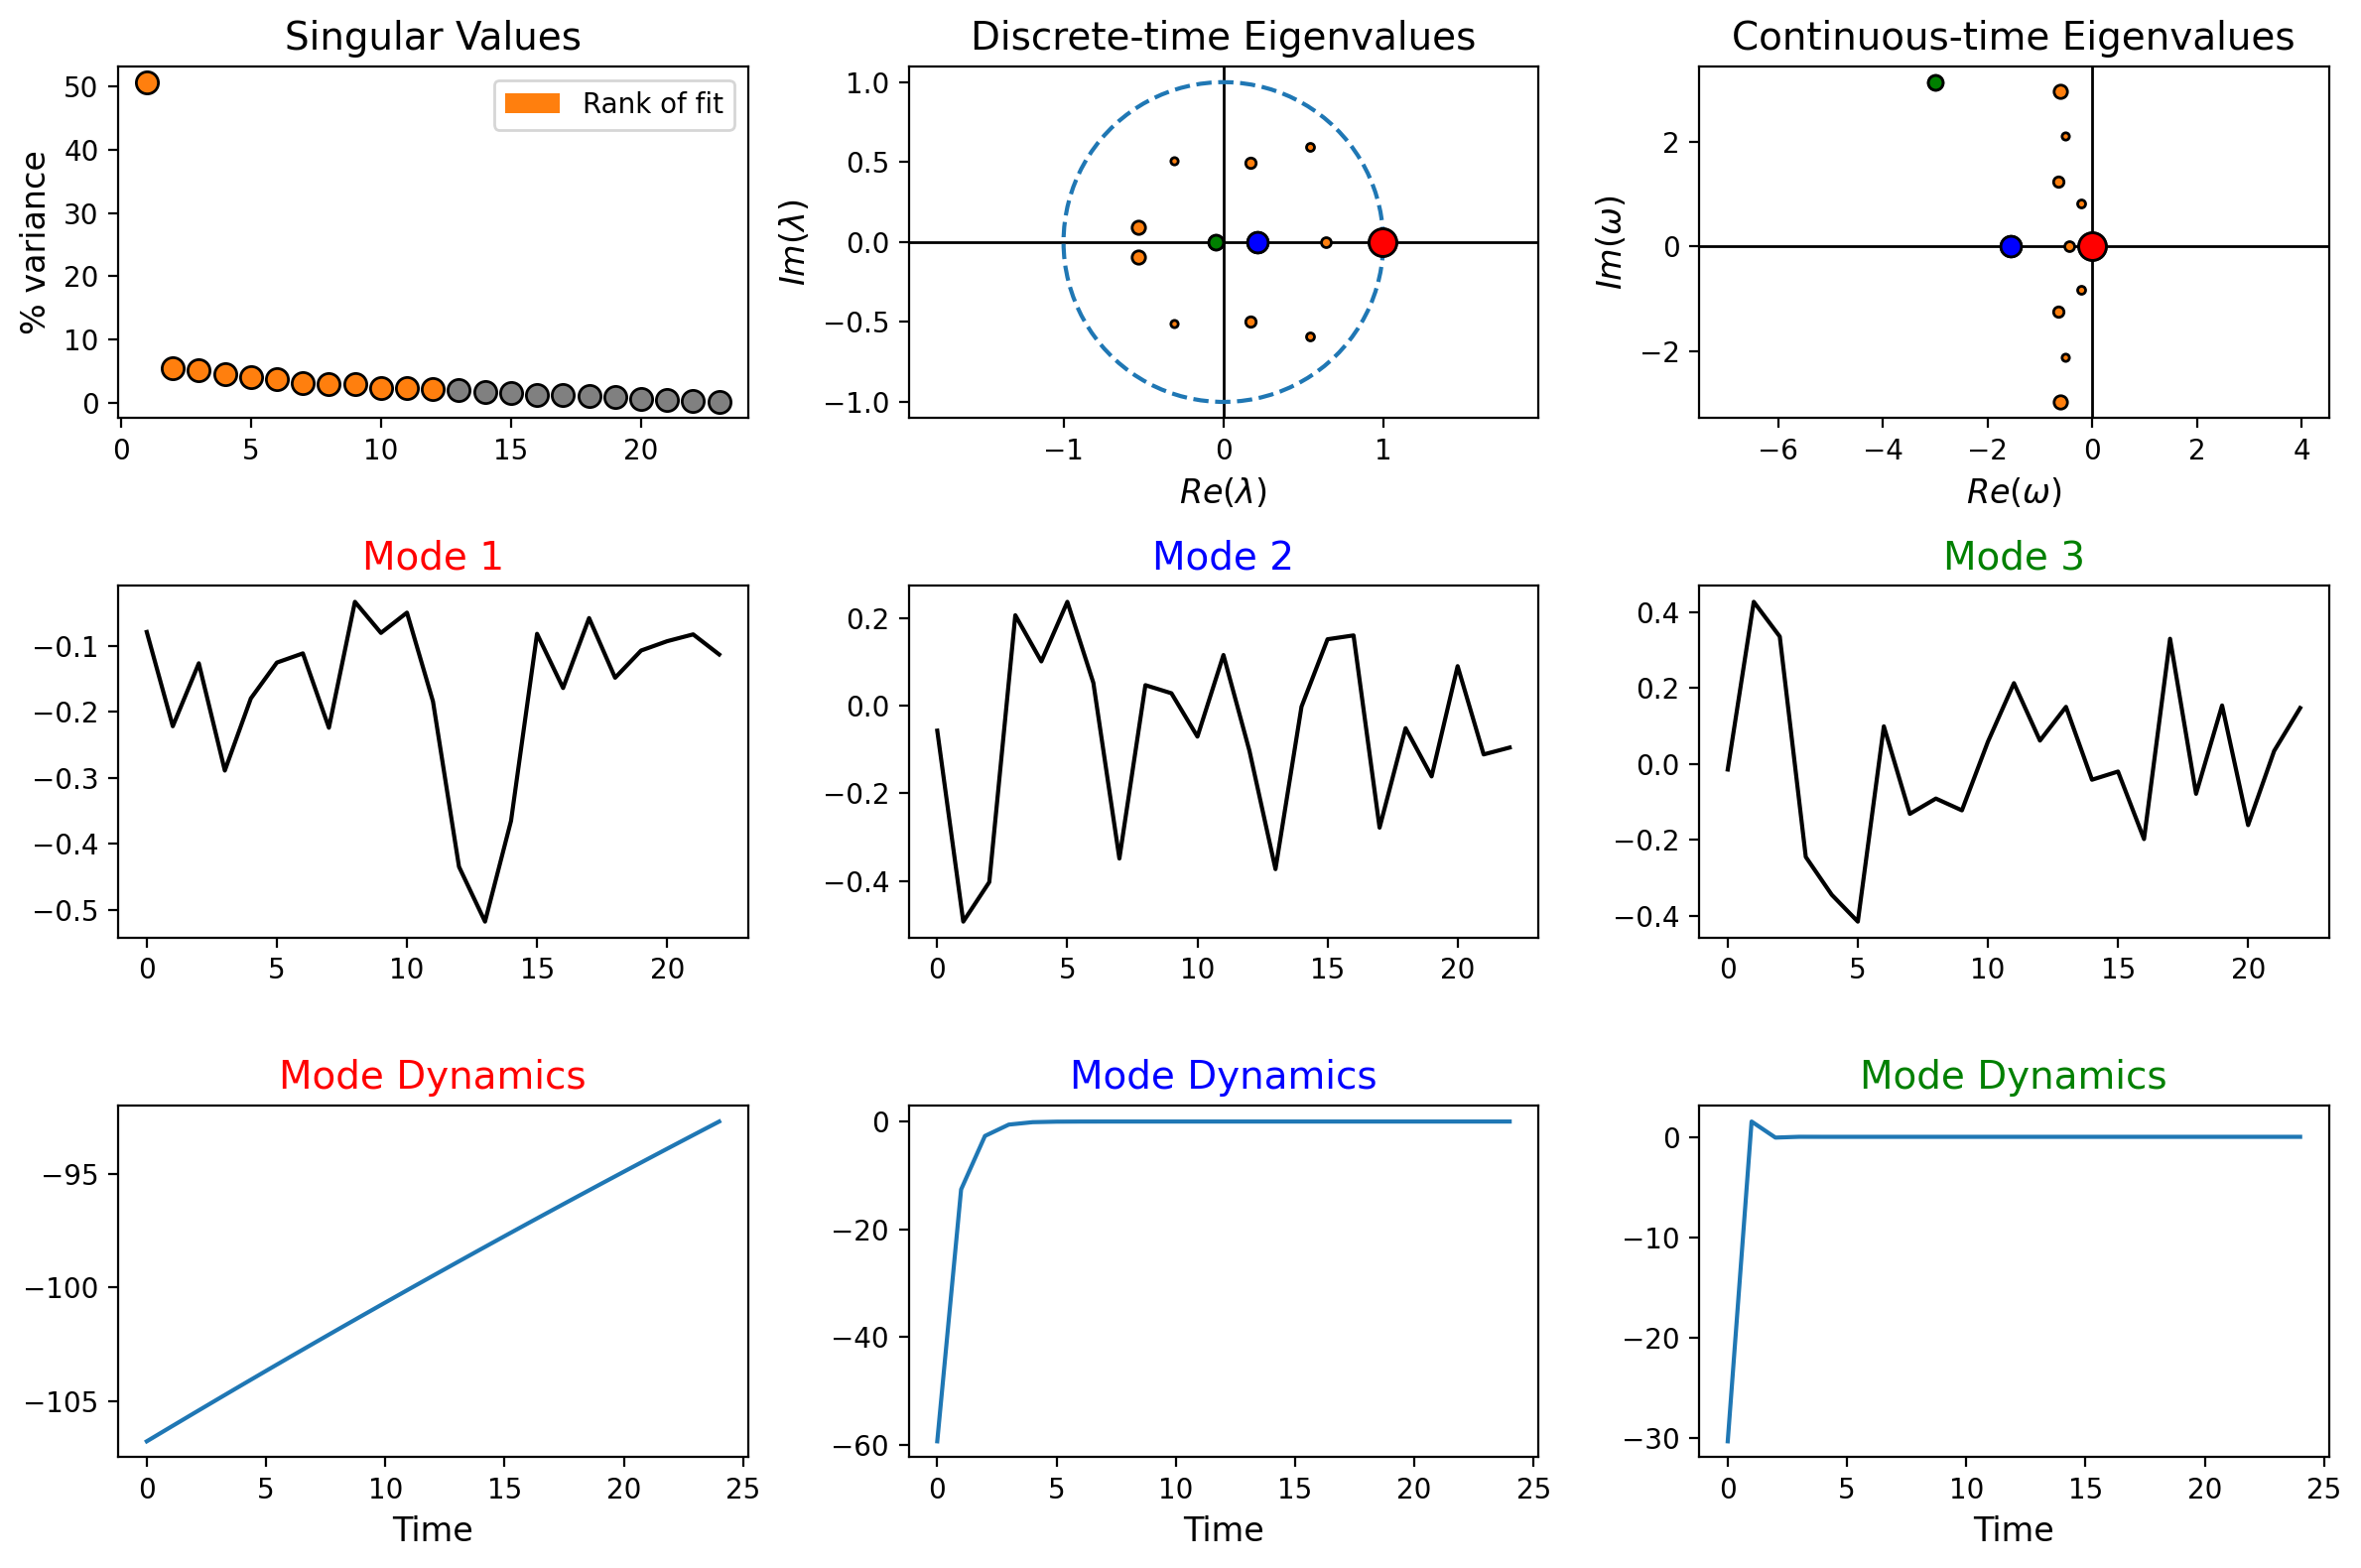

In [24]:
from pydmd import DMD
from pydmd.plotter import plot_summary

dmd = DMD(svd_rank=12)
dmd.fit(train_data)

plot_summary(dmd)
